# Exploratory Data Analysis

## Clean Data

In [1]:
import pandas as pd
from sklearn.utils import shuffle

# import datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Drop index column
train.drop('Index', axis=1)
test.drop('Index', axis=1)

# balance out the train dataset to have equal size of 0's and 1's
# Undersample 0's
positive = train[train['Sentiment']==1]
negative = train[train['Sentiment']==0]
negative = negative.sample(n=len(positive))
train = pd.concat([positive, negative], axis=0)
train = shuffle(train)
train = train.iloc[::50, :].reset_index(drop=True)

# Show dataset
print(test.head())
print(train.head())

   Index  Sentiment                                               Text
0      0          1  @stellargirl I loooooooovvvvvveee my Kindle2. ...
1      1          1  Reading my kindle2...  Love it... Lee childs i...
2      2          1  Ok, first assesment of the #kindle2 ...it fuck...
3      3          1  @kenburbary You'll love your Kindle2. I've had...
4      4          1  @mikefish  Fair enough. But i have the Kindle2...
    Index  Sentiment                                               Text
0  908838          1   phew!  made it thru the return of babysitting!  
1    1925          0  Going to sleep... hoping to wake up and tommor...
2  923718          1  Lunch, quick room-tidy, shave of head and face...
3  756325          0                             I have a bad headache 
4  919802          1  @Emmaloid you? hungover? never  I am not hungo...



In [2]:
# Check if any of dataset has missing values
print(test.isna().sum())
print(train.isna().sum())

Index        0
Sentiment    0
Text         0
dtype: int64
Index        0
Sentiment    0
Text         0
dtype: int64


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

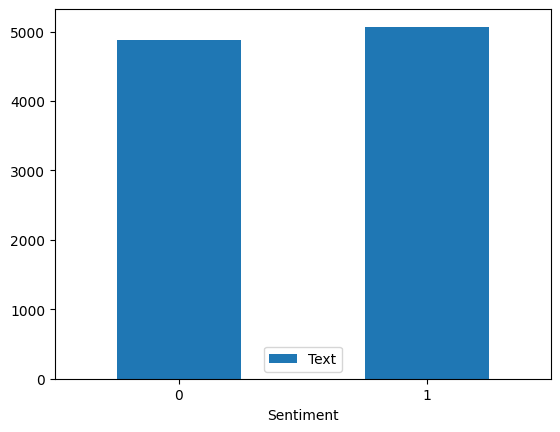

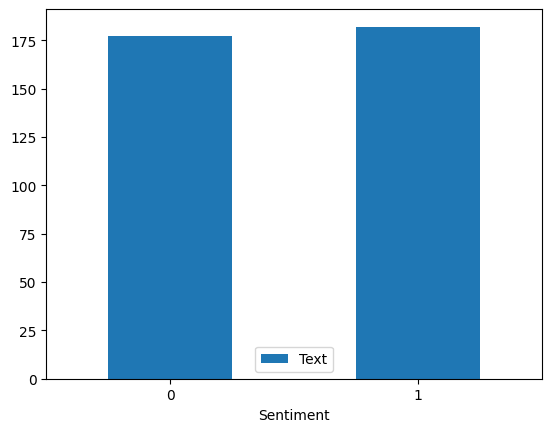

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Sentiment distribution for train dataset
train_senti = train.groupby('Sentiment').count()
train_senti = train_senti.drop(columns=['Index'])
train_senti.plot(kind='bar')
plt.xticks(rotation=0)

# Visualize sentiment distribution for test datastet
test_senti = test.groupby('Sentiment').count()
test_senti = test_senti.drop(columns=['Index'])
test_senti.plot(kind='bar')
plt.xticks(rotation=0)

# Text Preprocessing

In [4]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [5]:
def preprocess(column):

    # Lowercase the text
    step_2_corpus=column.lower()

    # deconcentrate
    step_3_corpus = re.sub(r"won\'t", "will not", step_2_corpus)
    step_3_corpus = re.sub(r"can\'t", "can not", step_3_corpus)
    step_3_corpus = re.sub(r"n\'t", " not", step_3_corpus)
    step_3_corpus = re.sub(r"\'re", " are", step_3_corpus)
    step_3_corpus = re.sub(r"\'s", " is", step_3_corpus)
    step_3_corpus = re.sub(r"\'d", " would", step_3_corpus)
    step_3_corpus = re.sub(r"\'t", " not", step_3_corpus)
    step_3_corpus = re.sub(r"\'ll", " will", step_3_corpus)
    step_3_corpus = re.sub(r"\'ve", " have", step_3_corpus)
    step_3_corpus = re.sub(r"\'m", " am", step_3_corpus)

    # Remove digits and special characters
    step_4_corpus = re.sub('[0-9]', '', step_3_corpus)
    step_4_corpus = re.sub("[^a-z0-9<>]", ' ', step_4_corpus)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    step_5_corpus = [w for w in step_4_corpus.split() if not w in stopwords.words('english')]

    # Stemming
    stemmer = SnowballStemmer('english')
    step_6_corpus=[]
    for word in step_5_corpus:
        stemmed_word = stemmer.stem(word)
        step_6_corpus.append(stemmed_word)

    new_sentence = " ".join(step_6_corpus)
    return new_sentence

In [6]:
# Preprocess train and test datasets
train['Preprocess'] = train['Text'].apply(preprocess)
test['Preprocess'] = test['Text'].apply(preprocess)

# Linguistic Feature Extraction

In [7]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare y value (dependent variable), Sentiment
y_train = train.iloc[:, 1]
y_test = test.iloc[:, 1]

## Bag of Words

In [8]:
# Prepare data for BOW
vectorizer = CountVectorizer(max_features=1000)

# fit, transform & split train data
X_train_counts = vectorizer.fit_transform(train['Preprocess'])
X_train_BOW = X_train_counts.toarray().tolist()
X_train_BOW_split, X_test_BOW_split, y_train_BOW_split, y_test_BOW_split = train_test_split(X_train_BOW, y_train)

# transform & split test data
X_test_counts = vectorizer.transform(test['Preprocess'])
X_test_BOW = X_test_counts.toarray().tolist()

## TF * IDF

In [9]:
# Prepare TF IDF train and test dataset
tfidf_converter = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_converter.fit_transform(train['Preprocess']).toarray()

# Split train data into train and test
X_train_tfidf_split, X_test_tfidf_split, y_train_tfidf_split, y_test_tfidf_split = train_test_split(X_train_tfidf, y_train)

# Prepare test data (transform)
X_test_tfidf = tfidf_converter.transform(test['Preprocess']).toarray()

## Word2vec

In [10]:
import gensim

# Turn preprocessed string into list of words
train['Preprocess - Word2Vec'] = train['Preprocess'].apply(lambda x: gensim.utils.simple_preprocess(x))
test['Preprocess - Word2Vec'] = test['Preprocess'].apply(lambda x: gensim.utils.simple_preprocess(x))

In [11]:
# Split the train dataset
X_train_w2v_split, X_test_w2v_split, y_train_w2v_split, y_test_w2v_split = train_test_split(
                                                train['Preprocess - Word2Vec'], y_train)

# Reset index of splitted data for dropping rows later
y_train_w2v_split = y_train_w2v_split.reset_index(drop=True)
y_test_w2v_split = y_test_w2v_split.reset_index(drop=True)

In [12]:
# Train w2v model on splitted train data
w2v_model = gensim.models.Word2Vec(X_train_w2v_split,
                                   vector_size=1000,
                                   window=5,
                                   min_count=2)

# Words that are most related to 'die'
w2v_model.wv.most_similar('die')

[('amp', 0.9999384880065918),
 ('got', 0.9999359846115112),
 ('one', 0.9999354481697083),
 ('get', 0.9999346733093262),
 ('watch', 0.9999340176582336),
 ('lol', 0.9999338388442993),
 ('still', 0.9999331831932068),
 ('come', 0.9999328851699829),
 ('love', 0.999932587146759),
 ('make', 0.9999324679374695)]

In [13]:
# Vectorize splitted train data
X_train_w2v_vector_split = []
train_drop_y = []

# Take the summation of word vectors for every sentence
for i, sentence in enumerate(X_train_w2v_split):
    
    sentence_vectors = [w2v_model.wv[word] for word in sentence if word in w2v_model.wv]
    
    if sentence_vectors:
        sentence_vector = np.sum(sentence_vectors, axis=0)
        X_train_w2v_vector_split.append(sentence_vector)
    
    else:
        train_drop_y.append(i)

# Convert list of train vectors into a 2D array
X_train_w2v_vector_split = np.vstack(X_train_w2v_vector_split)
y_train_w2v_split = y_train_w2v_split.drop(index=train_drop_y)

In [14]:
# Vectorize the test data
X_test_w2v_vector = []
test_drop_y = []

for i, sentence in enumerate(test['Preprocess - Word2Vec']):
    
    sentence_vectors = [w2v_model.wv[word] for word in sentence if word in w2v_model.wv]
    
    if sentence_vectors:
        sentence_vector = np.sum(sentence_vectors, axis=0)
        X_test_w2v_vector.append(sentence_vector)
    
    else:
        test_drop_y.append(i)

# Convert list of train vectors into a 2D array
X_test_w2v_vector = np.vstack(X_test_w2v_vector)
y_test_w2v = y_test.drop(index=test_drop_y)

# Classification Model Evaluation

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

lr = LogisticRegression()
svc = SVC(probability=True)
nb = GaussianNB()
rfc = RandomForestClassifier()

## Bag of Words

In [16]:
print("Bag of Words:")

# Logistic Regression
lr.fit(X_train_BOW_split, y_train_BOW_split)
#y_pred_BOW_lr = lr.predict(X_test_BOW_split)
print("Logistic Regression")
#print(classification_report(y_test_tfidf_split, y_pred_BOW_lr))

y_pred_BOW_lr = lr.predict(X_test_BOW)
print(classification_report(y_test, y_pred_BOW_lr))
print()

# SVM
svc.fit(X_train_BOW_split, y_train_BOW_split)
#y_pred_BOW_SVM = svc.predict(X_test_BOW_split)
print("Standard Vector Machine")
#print(classification_report(y_test_tfidf_split, y_pred_BOW_SVM))

y_pred_BOW_SVM = svc.predict(X_test_BOW)
print(classification_report(y_test, y_pred_BOW_SVM))
print()

# Naive Bay
nb.fit(X_train_BOW_split, y_train_BOW_split)
#y_pred_BOW_nb = nb.predict(X_test_BOW_split)
print("Naive Bayes classification")
#print(classification_report(y_test_tfidf_split, y_pred_BOW_nb))

y_pred_BOW_nb = nb.predict(X_test_BOW)
print(classification_report(y_test, y_pred_BOW_nb))
print()

# Random Forest
rfc.fit(X_train_BOW_split, y_train_BOW_split)
#y_pred_BOW_rfc = rfc.predict(X_test_BOW_split)
print("Random Forest classification")
#print(classification_report(y_test_tfidf_split, y_pred_BOW_rfc))

y_pred_BOW_rfc = rfc.predict(X_test_BOW)
print(classification_report(y_test, y_pred_BOW_rfc))

Bag of Words:
Logistic Regression
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       177
           1       0.73      0.84      0.78       182

    accuracy                           0.76       359
   macro avg       0.77      0.76      0.76       359
weighted avg       0.77      0.76      0.76       359


Standard Vector Machine
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       177
           1       0.71      0.85      0.77       182

    accuracy                           0.74       359
   macro avg       0.75      0.74      0.74       359
weighted avg       0.75      0.74      0.74       359


Naive Bayes classification
              precision    recall  f1-score   support

           0       0.73      0.55      0.63       177
           1       0.65      0.80      0.72       182

    accuracy                           0.68       359
   macro avg       0.69      0.68      0.

## TF IDF

In [17]:
print("TF IDF:")

# Logistic Regression
lr.fit(X_train_tfidf_split, y_train_tfidf_split)
print("Logistic Regression")
y_pred_tfidf_lr = lr.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_tfidf_lr))
print()

# SVM
svc.fit(X_train_tfidf_split, y_train_tfidf_split)
print("Standard Vector Machine")
y_pred_tfidf_SVM = svc.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_tfidf_SVM))
print()

# Naive Bayes
nb.fit(X_train_tfidf_split, y_train_tfidf_split)
print("Naive Bayes")
y_pred_tfidf_nb = nb.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_tfidf_nb))
print()

# Random Forest
rfc.fit(X_train_tfidf_split, y_train_tfidf_split)
print("Naive Bayes")
y_pred_tfidf_rfc = rfc.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_tfidf_rfc))

TF IDF:
Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.67      0.73       177
           1       0.73      0.85      0.78       182

    accuracy                           0.76       359
   macro avg       0.77      0.76      0.76       359
weighted avg       0.77      0.76      0.76       359


Standard Vector Machine
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       177
           1       0.72      0.83      0.77       182

    accuracy                           0.75       359
   macro avg       0.75      0.75      0.74       359
weighted avg       0.75      0.75      0.74       359


Naive Bayes
              precision    recall  f1-score   support

           0       0.76      0.61      0.68       177
           1       0.68      0.81      0.74       182

    accuracy                           0.71       359
   macro avg       0.72      0.71      0.71       359
weighted

## Word 2 Vector

In [18]:
# Logistic Regression
lr.fit(X_train_w2v_vector_split, y_train_w2v_split)
y_pred_w2v_lr = lr.predict(X_test_w2v_vector)
print("Logistic Regression")
print(classification_report(y_test_w2v, y_pred_w2v_lr))
print()

# SVM
svc.fit(X_train_w2v_vector_split, y_train_w2v_split)
y_pred_w2v_svc = svc.predict(X_test_w2v_vector)
print("SVM")
print(classification_report(y_test_w2v, y_pred_w2v_svc))
print()

# Naive Bayes
nb.fit(X_train_w2v_vector_split, y_train_w2v_split)
y_pred_w2v_nb = nb.predict(X_test_w2v_vector)
print("Naive Bayes classification")
print(classification_report(y_test_w2v, y_pred_w2v_nb))
print()

# Random Forest
rfc.fit(X_train_w2v_vector_split, y_train_w2v_split)
y_pred_w2v_rfc = rfc.predict(X_test_w2v_vector)
print(classification_report(y_test_w2v, y_pred_w2v_rfc))

Logistic Regression
              precision    recall  f1-score   support

           0       0.64      0.60      0.62       177
           1       0.63      0.66      0.64       179

    accuracy                           0.63       356
   macro avg       0.63      0.63      0.63       356
weighted avg       0.63      0.63      0.63       356


SVM
              precision    recall  f1-score   support

           0       0.43      0.14      0.21       177
           1       0.49      0.82      0.61       179

    accuracy                           0.48       356
   macro avg       0.46      0.48      0.41       356
weighted avg       0.46      0.48      0.41       356


Naive Bayes classification
              precision    recall  f1-score   support

           0       0.48      0.32      0.38       177
           1       0.50      0.66      0.57       179

    accuracy                           0.49       356
   macro avg       0.49      0.49      0.48       356
weighted avg       0.